# Exercise 8
## 2  Non-negative matrix factorization
### Setup

In [2]:
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.datasets import load_digits
from sklearn import decomposition
from scipy import sparse as sp
digits = load_digits ()
X = digits ["data" ]/255.
Y = digits ["target"]

### 2.1 Comparison of scikit-learn's NMF with SVD

In [3]:
def largestNIndices(a,n,axis=1):
    ind=np.unravel_index(a.flatten().argsort()[::-1],a.shape)[axis]
    return np.argsort(np.unique(ind,return_index=True)[1])[:n]

In [4]:
def plotEigVec(v):
    fig=plt.figure(figsize=(9,6))
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(v[i].reshape(8,8),cmap='gray')
        plt.title(i+1)
        plt.axis('off')

In [5]:
#SVD
Xmean=np.mean(X,axis=0)
X_tilde=X-Xmean
u,s,vh=np.linalg.svd(X_tilde)
#row indices for the 6 largest values in vh
#save in SVD_mir (most important rows)
SVD_mir=largestNIndices(vh,6,1)
svdBasis=vh.T[SVD_mir]+Xmean

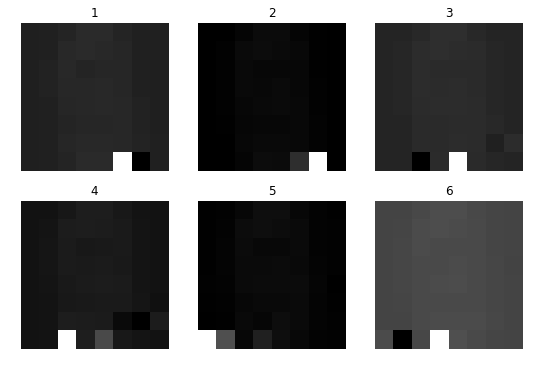

In [6]:
plotEigVec(svdBasis)

In [7]:
#sklearn's NMF
nmf=decomposition.NMF(n_components=10, init='random',random_state=0)
Z=nmf.fit_transform(X)
H=nmf.components_
NMF_mir=largestNIndices(H,6,0)

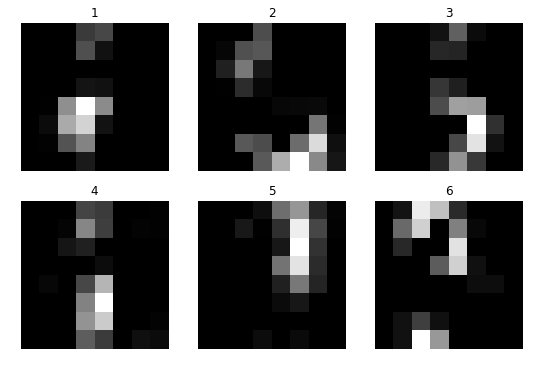

In [8]:
plotEigVec(H[NMF_mir])

The results of the SVT implementantion are hard to interpret since it highlights features which we considered to be rather unimportant. In contrast NMF returned basis vectors which at least show lines that resemble parts of numbers. 

### 2.2 Implementation

In [9]:
def non_negative(data,num_components,T=1000,returnLoss=False,update=False):
    X=data
    a,b=X.shape
    #initialize  H,Z:
    H_t,Z_t=np.abs(np.random.normal(size=(num_components,b))),np.abs(np.random.normal(size=(a,num_components)))
    #initialize updated H,Z
    H,Z=None,None
    #squared loss
    loss=[]
    for t in range(T):
        H=np.multiply(H_t,np.divide(Z_t.T@X,np.clip(Z_t.T@Z_t@H_t,1e-6,None)))
        Z=np.multiply(Z_t,np.divide(X@H.T,np.clip(Z_t@H@H.T,1e-6,None)))
        H_t,Z_t=H,Z
        loss.append(np.linalg.norm(X-Z_t@H_t)**2)
        if update:
            print('%i/%i'%(t+1,T),end='\r')
    return (H_t,Z_t,loss) if returnLoss else (H_t,Z_t)

In [10]:
h,z,l=non_negative(X,6,returnLoss=True)

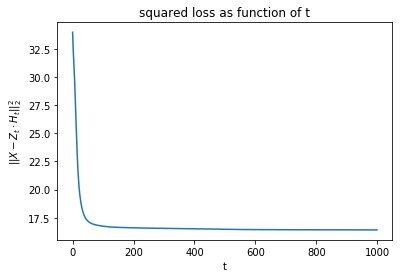

In [11]:
plt.plot(l)
plt.title('squared loss as function of t')
plt.xlabel('t')
plt.ylabel('$||X-Z_t\cdot H_t||^2_2$')
plt.show()

In [12]:
np.count_nonzero(np.gradient(l)>0)

0

That shows that the squared loss is non-increasing with $t$.

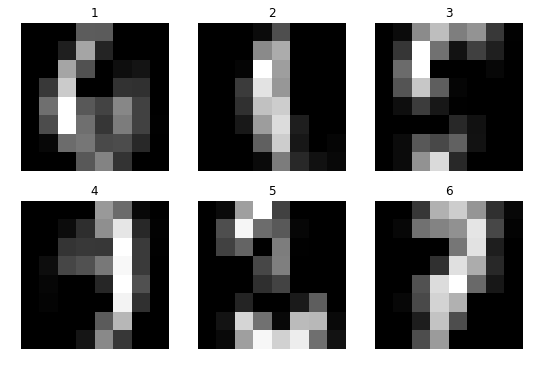

In [13]:
plotEigVec(h[largestNIndices(h,6,0)])

looks similar to the NMF result using <tt>scikit-learn</tt>

## 3 Recommender system

In [14]:
import pandas as pd # install pandas via conda
# column headers for the dataset
ratings_cols = ['user id','movie id','rating','timestamp']
movies_cols = ['movie id','movie title','release date',
'video release date','IMDb URL','unknown','Action',
'Adventure','Animation','Childrens','Comedy','Crime',
' Documentary','Drama','Fantasy','Film-Noir','Horror',
'Musical','Mystery','Romance','Sci-Fi','Thriller',
'War' ,'Western']
users_cols = ['user id','age','gender','occupation','zip code']
users = pd.read_csv('ml-100k/u.user', sep ='|',names = users_cols , encoding ='latin-1')
movies = pd.read_csv('ml-100k/u.item', sep='|',names = movies_cols , encoding ='latin-1')

ratings = pd.read_csv('ml-100k/u.data', sep ='\t',names = ratings_cols , encoding ='latin-1')

# create a joint ratings dataframe for the matrix

rat_df = ratings.pivot(index ='user id',columns ='movie id', values ='rating')
fill_value = 0#rat_df.mean()
rat_df.fillna(fill_value,inplace=True)
rat_df.head()

movie id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
H,Z=non_negative(rat_df,15,update=True)

In [16]:
#percent of nonrated movies in total:
100-100*sp.coo_matrix(rat_df).nnz/np.prod(rat_df.shape)

93.69533063577546

In [17]:
100-100*sp.coo_matrix(Z@H).nnz/np.prod(rat_df.shape)

0.11587982291445087

In [86]:
reconstruction=pd.DataFrame(Z@H,columns=rat_df.columns)

In [138]:
def recommend_movies(reconstruction , user_id , movies , ratings):
    possibleRatings=reconstruction.ix[user_id] #1...
    #find all already rated movies of this user
    ratedMovies=ratings.loc[ratings['user id']==user_id].T.ix['movie id'] #1...
    #remove those movies from the list
    movieIndices=np.delete(possibleRatings.index,ratedMovies-1) #1 indexing
    #rec=reconstruction.ix[user_id][movieIndices].sort_values(ascending=False).index
    rec=possibleRatings[movieIndices].sort_values(ascending=False).index
    #retrun only movies with a recommendation of 2.5 or higher
    #rec=np.where(possibleRatings[movieIndices]>2.5)[0]#rec[possibleRatings[movieIndices]>=2.5]
    #now return the names of all movies listed by rating
    return movies.ix[rec][:20]

In [45]:
recommend_movies(reconstruction,1,movies,ratings)['movie title']

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1

movie id
273                                     Sabrina (1995)
274                       Sense and Sensibility (1995)
275                           Leaving Las Vegas (1995)
276                                 Restoration (1995)
277                                Bed of Roses (1996)
278    Once Upon a Time... When We Were Colored (1995)
279                       Up Close and Personal (1996)
280                             River Wild, The (1994)
281                             Time to Kill, A (1996)
282                                        Emma (1996)
283                                     Tin Cup (1996)
284                              Secrets & Lies (1996)
285                        English Patient, The (1996)
286                               Marvin's Room (1996)
287                                      Scream (1996)
288                                       Evita (1996)
289                            Fierce Creatures (1997)
290                              Absolute Power (1997)
2

In [46]:
movies['movie title'][np.where(rat_df.ix[1]>.5)[0]]

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


0                                       Toy Story (1995)
1                                       GoldenEye (1995)
2                                      Four Rooms (1995)
3                                      Get Shorty (1995)
4                                         Copycat (1995)
5      Shanghai Triad (Yao a yao yao dao waipo qiao) ...
6                                  Twelve Monkeys (1995)
7                                            Babe (1995)
8                                Dead Man Walking (1995)
9                                     Richard III (1995)
10                                  Seven (Se7en) (1995)
11                            Usual Suspects, The (1995)
12                               Mighty Aphrodite (1995)
13                                    Postino, Il (1994)
14                             Mr. Holland's Opus (1995)
15                    French Twist (Gazon maudit) (1995)
16                            From Dusk Till Dawn (1996)
17                             

In [87]:
ownRating=np.zeros(1682)
ratingIndex = np.array([0,21,49,55,63,68,70,81,90,134,153,171,178,180,200,209,248,249,287,383,454,549,553,598,664]) 
ratingValue = np.array([4,4,5,4,5,5,4,3,4,4,4,4,4,5,5,4,5,3,4,5,5,5,4,4,4])
ownRating[ratingIndex] = ratingValue
newrat_df = rat_df.append(pd.DataFrame([ownRating],columns=np.arange(1,1683),index=[944],dtype=np.float64))

newratings = ratings.append(pd.DataFrame(np.transpose([[944]*len(ratingIndex),ratingIndex + 1, ratingValue, np.zeros(len(ratingIndex))]),
                            columns=ratings_cols,index=np.arange(10000,10000 + len(ratingIndex)),dtype=np.float64))

newusers = users.append(pd.DataFrame([[944,20,'M','student',55107]],columns=users_cols,dtype=object,index=[943]))

Hnew,Znew = non_negative(newrat_df,15,update=True)
newreconstruction=pd.DataFrame(Znew@Hnew,columns=newrat_df.columns)


In [139]:
recommend_movies(newreconstruction,944,movies,newratings)['movie title']

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documenta

movie id
174                             Brazil (1985)
98     Snow White and the Seven Dwarfs (1937)
100                        Heavy Metal (1981)
79                Hot Shots! Part Deux (1993)
96                  Dances with Wolves (1990)
173            Raiders of the Lost Ark (1981)
7                                 Babe (1995)
195                 Dead Poets Society (1989)
258               George of the Jungle (1997)
127                           Supercop (1992)
12                    Mighty Aphrodite (1995)
222                        Sling Blade (1996)
318           Everyone Says I Love You (1996)
257                            Contact (1997)
144                 Lawnmower Man, The (1992)
176    Good, The Bad and The Ugly, The (1966)
183                   Army of Darkness (1993)
168                Wrong Trousers, The (1993)
204                             Patton (1970)
11                 Usual Suspects, The (1995)
Name: movie title, dtype: object

We looked through the first 700 movies and rated every movie we knew. Since we didn't know all the english names me missed some. We have seen some of the recommended films and enjoyed them. Additionally some of the films look interesting shows that code produced reasonable results.